In [1]:
from tqdm import tqdm_notebook as tqdm

In [2]:
import numpy as np
import pandas as pd
from glob import glob as glob

In [3]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, QuantileTransformer

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
tf.__version__

'2.2.0'

In [5]:
from kerastuner import HyperParameters
from kerastuner.tuners import RandomSearch

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('notebook')

/anaconda3/envs/neuro/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 1. Data Preparation

In [7]:
# Load target values and corresponding scaler
targets = pd.read_csv('datasets/targets.csv')
targets = targets.rename(columns={'Unnamed: 0': 'Id'}).set_index('Id')
feature_transform = True

import joblib
scaler_targets = joblib.load('datasets/targets_scaler.pkl')

In [8]:
# Extract ID for train and test set
train_id = targets.index.values
sample_submission = pd.read_csv('sample_submission.csv')
test_id = np.unique(sample_submission.Id.str.split('_', expand=True)[0].astype('int'))

# 2. Modeling

In [9]:
def load_dataset(dataset_id):

    # Load dataset
    X_tr = pd.read_csv('datasets/%s_train.csv' % dataset_id)
    X_te = pd.read_csv('datasets/%s_test.csv' % dataset_id).drop(columns='Id').values

    # Specify target
    y = pd.read_csv('datasets/targets.csv')
    y = y.rename(columns={'Unnamed: 0': 'Id'}).set_index('Id')
    y_tr = y.iloc[X_tr.index]

    # Remove missing values
    missval = y_tr.isnull().values.sum(axis=1)>0
    idx = ~missval
    X_tr = X_tr[idx].drop(columns='Id').values
    y_tr = y_tr[idx].values
    print('Removing %s missing values from target dataset.' % missval.sum())
    
    return X_tr, X_te, y_tr, idx

In [10]:
class CustomLoss(keras.losses.Loss):
    def __init__(self, scale=[1, 1, 1, 1, 1], mean=[0, 0, 0, 0, 0], name="custom_loss"):
        super().__init__(name=name)
        self.scale = np.array(scale, dtype='float32')
        self.mean = np.array(mean, dtype='float32')

    @tf.function
    def call(self, y_true, y_pred):
        y_true = tf.math.add(tf.math.multiply(self.scale, y_true), self.mean)
        y_pred = tf.math.add(tf.math.multiply(self.scale, y_pred), self.mean)

        y_true = tf.transpose(tf.stack([
            y_true[:, 0],
            tf.math.pow(y_true[:, 1], 1./1.5),
            tf.math.pow(y_true[:, 2], 1./1.5),
            tf.math.pow(y_true[:, 3], 1./1.5),
            tf.math.pow(y_true[:, 4], 1./1.5)]))

        y_pred = tf.transpose(tf.stack([
            y_pred[:, 0],
            tf.math.pow(y_pred[:, 1], 1./1.5),
            tf.math.pow(y_pred[:, 2], 1./1.5),
            tf.math.pow(y_pred[:, 3], 1./1.5),
            tf.math.pow(y_pred[:, 4], 1./1.5)]))
        scores = tf.math.divide(tf.math.reduce_sum(tf.math.abs(y_true - y_pred), axis=0),
                                tf.math.reduce_sum(y_true, axis=0))
        weights = np.array([.3, .175, .175, .175, .175], dtype='float32')
        return tf.math.reduce_sum(tf.math.multiply(weights, scores))

In [11]:
# Specify dataset ID
dataset_id = 'merge'

In [12]:
# Extract dataset
X_tr, X_te, y_tr, idx = load_dataset(dataset_id)
print('Size of dataset: ', X_tr.shape)

Removing 440 missing values from target dataset.
Size of dataset:  (5385, 1404)


In [13]:
# Create grid search object
grid = {'scaler': RobustScaler(),
        'pca': None}

In [14]:
# Scale data
if grid['scaler']:
    x_train = grid['scaler'].fit_transform(X_tr)
    x_test = grid['scaler'].transform(X_te)

    # Apply PCA
    if grid['pca']:
        pca = grid['pca']
        x_train = pca.fit_transform(x_train)
        x_test = pca.transform(x_test)
else:
    x_train = X_tr.copy()
    x_test = X_te.copy()

print(x_train.shape)

(5385, 1404)


In [15]:
def build_model(hp):
    
    model = keras.Sequential()
    model.add(layers.Input(shape=1404))
    kernel_init=hp.Choice('kernel_initializer', values=['uniform'])
    activation=hp.Choice('activation', values=[
        'elu', 'relu', 'selu', 'softplus', 'softsign', 'swish',
        'sigmoid', 'hard_sigmoid', 'linear', 'tanh'])
    #dropout=hp.Boolean('dropout')
    dropout = True
    #dropout_rate=hp.Choice('dropout_rate', values=[0.2])
    dropout_rate = 0.2
    #batchnorm=hp.Boolean('batchnorm')
    batchnorm = True
    
    for i in range(hp.Int('n_layers', min_value=2, max_value=3)):
        model.add(layers.Dense(units=hp.Int(f"dense_{i}_units", min_value=32, max_value=416, step=64),
                               kernel_initializer=kernel_init))
        if batchnorm:
            model.add(layers.BatchNormalization())
        model.add(layers.Activation('sigmoid'))
    if dropout:
        model.add(layers.Dropout(dropout_rate))

    # Final output layer
    model.add(layers.Dense(5))
    
    # Define loss function, optimizer and metrics to track during training
    learning_rate = hp.Choice('learning_rate', values=[1e-2])
    model.compile(optimizer = keras.optimizers.Adagrad(learning_rate)
    )

    return model

In [16]:
import time
LOG_DIR = f"{int(time.time())}"
LOG_DIR

tuner = RandomSearch(
    build_model,
    loss = CustomLoss(scale=scaler_targets.scale_, mean=scaler_targets.mean_),
    objective='val_loss',
    max_trials=100,
    executions_per_trial=1,
    directory=LOG_DIR)

In [ ]:
tuner.search(x_train, y_tr,
             epochs=50,
             batch_size=64,
             validation_split=0.2)

In [18]:
# Show best hyperparameters
tuner.get_best_hyperparameters()[0].values

{'kernel_initializer': 'uniform',
 'activation': 'linear',
 'dropout_rate': 0.2,
 'n_layers': 2,
 'dense_0_units': 96,
 'dense_1_units': 32,
 'learning_rate': 0.01,
 'dense_2_units': 288}

In [19]:
# Print results
tuner.results_summary(num_trials=100)

In [20]:
# Compute predictions according to best model
model = tuner.get_best_models()[0]

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 96)                134880    
_________________________________________________________________
batch_normalization (BatchNo (None, 96)                384       
_________________________________________________________________
batch_normalization_1 (Batch (None, 96)                384       
_________________________________________________________________
activation (Activation)      (None, 96)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                3104      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32)                128       
_________________________________________________________________
batch_normalization_3 (Batch (None, 32)                1

In [22]:
model.evaluate(x_train, y_tr)

169/169 [==============================] - ETA: 0s - loss: 0.164 - ETA: 0s - loss: 0.151 - ETA: 0s - loss: 0.150 - 0s 799us/step - loss: 0.1522


0.15223434567451477

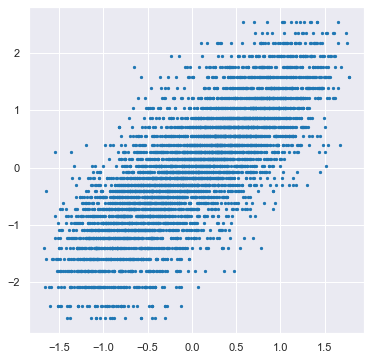

In [23]:
y_pred_train = model.predict(x_train)
plt.figure(figsize=(6, 6))
plt.scatter(y_pred_train[:, 0], y_tr[:, 0], s=5);